# **Module 4: Spatial Dependence and Regression**
## **Prerequisites**
### Data
For this workshop, data are created and saved to the directory `./data-module-4/`.
- `mnp.shp` -  a pseudo dataset representing hypothetical pest stress for selected Minnesota counties.
### Software
To execute the code you will need a Python environment with the packages imported below. The default environment does not have all required packages to execute this script. Therefore, run the following command beforehand:
- `pip install pysal --user`

In [1]:
# general use packages
import numpy as np
import matplotlib.pyplot as plt

# geospatial packages
import geopandas as gpd
from pysal.lib import weights
from spreg import ML_Lag, ML_Error, OLS
from splot.libpysal import plot_spatial_weights
import esda 
from splot.esda import plot_moran

import os
os.environ['PROJ_LIB'] = '/opt/conda/envs/user_default/share/proj'

/home/u01000486/.local/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/home/u01000486/.local/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/home/u01000486/.local/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:198: NumbaDep

### Read and visualize input data

In [2]:
mnp = gpd.read_file("./data-module-4/mnp.shp")
print ("Coordinate reference system is {}".format(mnp.crs))
print ("Number of records is {}".format(len(mnp)))
mnp.head()

Coordinate reference system is EPSG:26915
Number of records is 41


,COUNTYFIPS,COUNTYNAME,HOST,PEST,geometry
0,013,Blue Earth,7.070996,101.373005,"POLYGON ((390506.856 4902151.077, 390511.850 4..."
1,015,Brown,5.333409,87.899395,"POLYGON ((358342.018 4924074.276, 358342.521 4..."
2,019,Carver,5.926490,45.360617,"POLYGON ((439502.612 4980761.193, 439476.618 4..."
3,023,Chippewa,5.664981,74.068789,"POLYGON ((323409.909 5002337.605, 323356.939 5..."
4,033,Cottonwood,5.659359,90.921421,"POLYGON ((303222.915 4896582.925, 304066.172 4..."


Text(0.5, 1.0, 'Minnesota Pest Pressure for selected counties')

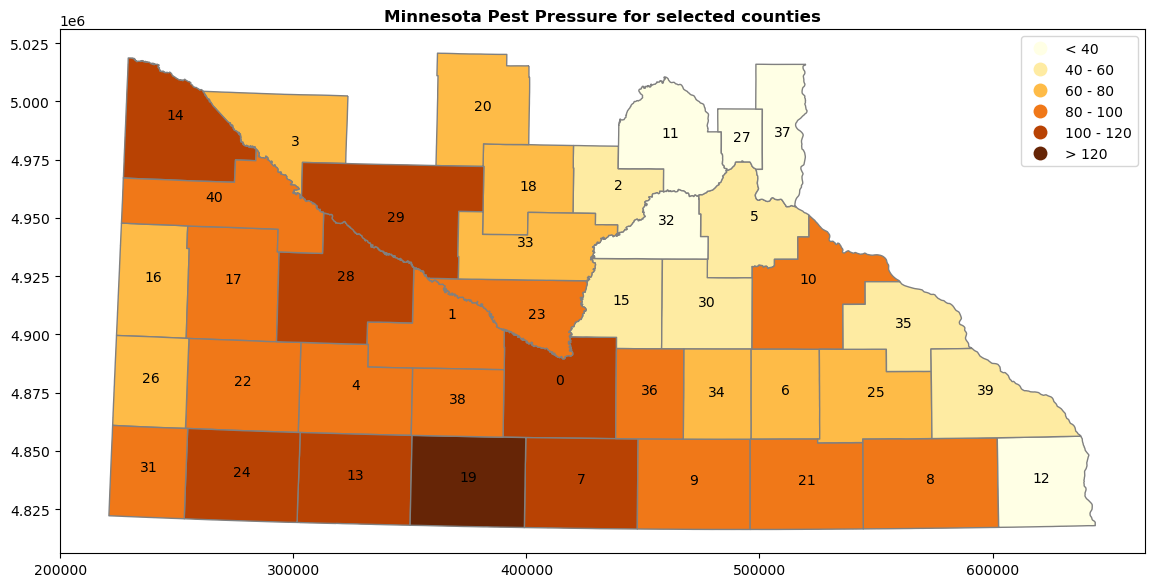

In [3]:
fig, ax = plt.subplots(figsize=(14,8))
mnp.plot(ax=ax, column="PEST", legend=True, scheme="User_Defined", cmap="YlOrBr", 
         edgecolor="grey", classification_kwds=dict(bins=[40,60,80,100,120]),
         legend_kwds={"labels": ["< 40", "40 - 60", "60 - 80", "80 - 100", "100 - 120", "> 120"]})
mnp["coords"] = mnp["geometry"].apply(lambda x: x.representative_point().coords[:])
mnp["coords"] = [coords[0] for coords in mnp["coords"]]
for idx, row in mnp.iterrows():
    ax.annotate(text=idx, xy=row["coords"],
                 horizontalalignment="center")
ax.set_title("Minnesota Pest Pressure for selected counties", weight="bold")

### Spatial weights (contiguity and distance-based)

#### Queen's case (contiguity)

In [4]:
# calculate neighboring using Queen's case (contiguity)
mnp_nbq = weights.contiguity.Queen.from_dataframe(mnp)
# summarize 
print ("Number of units: {}".format(mnp_nbq.n))
print ("Number of nonzero weights: {}".format(mnp_nbq.nonzero))
print ("Percentage of nonzero weights: {}".format(mnp_nbq.pct_nonzero))
print ("Average number of neighbors: {}".format(mnp_nbq.mean_neighbors))
print ("Largest number of neighbors is {}".format(mnp_nbq.max_neighbors))
print ("Minimum number of neighbors is {}".format(mnp_nbq.min_neighbors))
print ("Number of units without any neighbors {}".format(len(mnp_nbq.islands)))
print ("Histogram: {}".format(mnp_nbq.histogram))
print ("Neighbour list: {}".format(mnp_nbq.neighbors))

Number of units: 41
Number of nonzero weights: 190
Percentage of nonzero weights: 11.302795954788817
Average number of neighbors: 4.634146341463414
Largest number of neighbors is 8
Minimum number of neighbors is 2
Number of units without any neighbors 0
Histogram: [(2, 4), (3, 5), (4, 11), (5, 7), (6, 11), (7, 2), (8, 1)]
Neighbour list: {0: [1, 19, 36, 23, 38, 7, 15], 1: [0, 4, 38, 23, 28, 29], 2: [32, 33, 18, 11], 3: [40, 29, 14], 4: [1, 38, 22, 24, 28, 13], 5: [32, 37, 11, 10, 27, 30], 6: [34, 21, 25, 10, 30], 7: [0, 9, 19, 36], 8: [25, 12, 21, 39], 9: [34, 36, 21, 7], 10: [35, 5, 6, 25, 30], 11: [32, 2, 27, 5], 12: [8, 39], 13: [24, 19, 4, 38], 14: [40, 3], 15: [0, 32, 33, 36, 23, 30], 16: [40, 17, 26], 17: [16, 22, 40, 26, 28], 18: [33, 2, 20, 29], 19: [0, 13, 38, 7], 20: [18, 29], 21: [34, 6, 8, 25, 9], 22: [17, 4, 24, 26, 28, 31], 23: [0, 1, 33, 29, 15], 24: [4, 13, 22, 31], 25: [35, 21, 6, 39, 8, 10], 26: [16, 17, 22, 31], 27: [11, 37, 5], 28: [1, 17, 4, 22, 40, 29], 29: [1, 33

#### Rook's case (contiguity)

In [5]:
# calculate neighboring using Rook's case (contiguity)
mnp_nbr = weights.contiguity.Rook.from_dataframe(mnp)
# summarize 
print ("Number of units: {}".format(mnp_nbr.n))
print ("Number of nonzero weights: {}".format(mnp_nbr.nonzero))
print ("Percentage of nonzero weights: {}".format(mnp_nbr.pct_nonzero))
print ("Average number of neighbors: {}".format(mnp_nbr.mean_neighbors))
print ("Largest number of neighbors is {}".format(mnp_nbr.max_neighbors))
print ("Minimum number of neighbors is {}".format(mnp_nbr.min_neighbors))
print ("Number of units without any neighbors {}".format(len(mnp_nbr.islands)))
print ("Histogram: {}".format(mnp_nbr.histogram))
print ("Neighbour list: {}".format(mnp_nbr.neighbors))

Number of units: 41
Number of nonzero weights: 190
Percentage of nonzero weights: 11.302795954788817
Average number of neighbors: 4.634146341463414
Largest number of neighbors is 8
Minimum number of neighbors is 2
Number of units without any neighbors 0
Histogram: [(2, 4), (3, 5), (4, 11), (5, 7), (6, 11), (7, 2), (8, 1)]
Neighbour list: {0: [1, 19, 36, 23, 38, 7, 15], 1: [0, 4, 38, 23, 28, 29], 2: [32, 33, 18, 11], 3: [40, 29, 14], 4: [1, 38, 22, 24, 28, 13], 5: [32, 37, 27, 10, 11, 30], 6: [34, 21, 25, 10, 30], 7: [0, 9, 19, 36], 8: [25, 12, 21, 39], 9: [34, 36, 21, 7], 10: [35, 5, 6, 25, 30], 11: [32, 2, 27, 5], 12: [8, 39], 13: [24, 19, 4, 38], 14: [40, 3], 15: [0, 33, 32, 36, 23, 30], 16: [40, 17, 26], 17: [16, 22, 40, 26, 28], 18: [33, 2, 20, 29], 19: [0, 13, 38, 7], 20: [18, 29], 21: [34, 6, 8, 9, 25], 22: [17, 4, 24, 26, 28, 31], 23: [0, 1, 33, 29, 15], 24: [4, 13, 22, 31], 25: [35, 21, 6, 39, 8, 10], 26: [16, 17, 22, 31], 27: [11, 37, 5], 28: [1, 17, 4, 22, 40, 29], 29: [1, 33

#### K-nearest neighbors (distance-based)

In [6]:
# calculate neighboring using K-nearest neighbors (distance-based)
mnp_nbk3 = weights.distance.KNN.from_dataframe(mnp, k=3)
# summarize 
print ("Number of units: {}".format(mnp_nbk3.n))
print ("Number of nonzero weights: {}".format(mnp_nbk3.nonzero))
print ("Percentage of nonzero weights: {}".format(mnp_nbk3.pct_nonzero))
print ("Average number of neighbors: {}".format(mnp_nbk3.mean_neighbors))
print ("Largest number of neighbors is {}".format(mnp_nbk3.max_neighbors))
print ("Minimum number of neighbors is {}".format(mnp_nbk3.min_neighbors))
print ("Number of units without any neighbors {}".format(len(mnp_nbk3.islands)))
print ("Histogram: {}".format(mnp_nbk3.histogram))
print ("Neighbour list: {}".format(mnp_nbk3.neighbors))

Number of units: 41
Number of nonzero weights: 123
Percentage of nonzero weights: 7.317073170731708
Average number of neighbors: 3.0
Largest number of neighbors is 3
Minimum number of neighbors is 3
Number of units without any neighbors 0
Histogram: [(3, 41)]
Neighbour list: {0: [23, 36, 7], 1: [38, 23, 4], 2: [32, 11, 18], 3: [40, 14, 29], 4: [13, 28, 1], 5: [32, 27, 30], 6: [34, 25, 21], 7: [0, 9, 36], 8: [39, 25, 12], 9: [34, 36, 21], 10: [5, 35, 6], 11: [27, 2, 32], 12: [39, 8, 25], 13: [4, 24, 19], 14: [40, 3, 16], 15: [32, 30, 36], 16: [17, 26, 40], 17: [40, 16, 22], 18: [33, 2, 20], 19: [38, 13, 7], 20: [18, 29, 33], 21: [6, 25, 9], 22: [24, 26, 17], 23: [33, 0, 1], 24: [22, 31, 13], 25: [35, 6, 8], 26: [31, 22, 16], 27: [37, 11, 5], 28: [29, 4, 1], 29: [28, 18, 20], 30: [15, 34, 32], 31: [26, 24, 22], 32: [2, 15, 5], 33: [23, 18, 2], 34: [36, 6, 30], 35: [25, 10, 39], 36: [34, 0, 15], 37: [27, 5, 11], 38: [1, 19, 0], 39: [12, 8, 35], 40: [17, 14, 3]}


#### Distance (distance-based)

In [7]:
# calculate neighboring by distance (distance-based)
mnp_nbd = weights.distance.DistanceBand.from_dataframe(mnp, 100000, binary=True)
# summarize 
print ("Number of units: {}".format(mnp_nbd.n))
print ("Number of nonzero weights: {}".format(mnp_nbd.nonzero))
print ("Percentage of nonzero weights: {}".format(mnp_nbd.pct_nonzero))
print ("Average number of neighbors: {}".format(mnp_nbd.mean_neighbors))
print ("Largest number of neighbors is {}".format(mnp_nbd.max_neighbors))
print ("Minimum number of neighbors is {}".format(mnp_nbd.min_neighbors))
print ("Number of units without any neighbors {}".format(len(mnp_nbd.islands)))
print ("Histogram: {}".format(mnp_nbd.histogram))
print ("Neighbour list: {}".format(mnp_nbd.neighbors))

Number of units: 41
Number of nonzero weights: 518
Percentage of nonzero weights: 30.814991076740036
Average number of neighbors: 12.634146341463415
Largest number of neighbors is 20
Minimum number of neighbors is 4
Number of units without any neighbors 0
Histogram: [(4, 1), (5, 1), (6, 0), (7, 3), (8, 1), (9, 4), (10, 3), (11, 5), (12, 4), (13, 2), (14, 0), (15, 4), (16, 4), (17, 4), (18, 3), (19, 1), (20, 1)]
Neighbour list: {0: [1, 2, 4, 6, 7, 9, 13, 15, 18, 19, 23, 30, 32, 33, 34, 36, 38], 1: [0, 2, 4, 7, 13, 15, 17, 18, 19, 20, 22, 23, 28, 29, 33, 36, 38], 2: [0, 1, 5, 10, 11, 15, 18, 20, 23, 27, 29, 30, 32, 33, 34, 36, 37], 3: [14, 16, 17, 20, 28, 29, 40], 4: [0, 1, 13, 16, 17, 19, 22, 23, 24, 26, 28, 29, 31, 33, 38, 40], 5: [2, 6, 10, 11, 15, 18, 25, 27, 30, 32, 33, 34, 35, 36, 37], 6: [0, 5, 7, 8, 9, 10, 15, 21, 25, 30, 32, 34, 35, 36, 39], 7: [0, 1, 6, 9, 13, 15, 19, 21, 23, 30, 34, 36, 38], 8: [6, 10, 12, 21, 25, 34, 35, 39], 9: [0, 6, 7, 10, 15, 19, 21, 25, 30, 34, 36], 10: 

### Visualize and compare weights networks

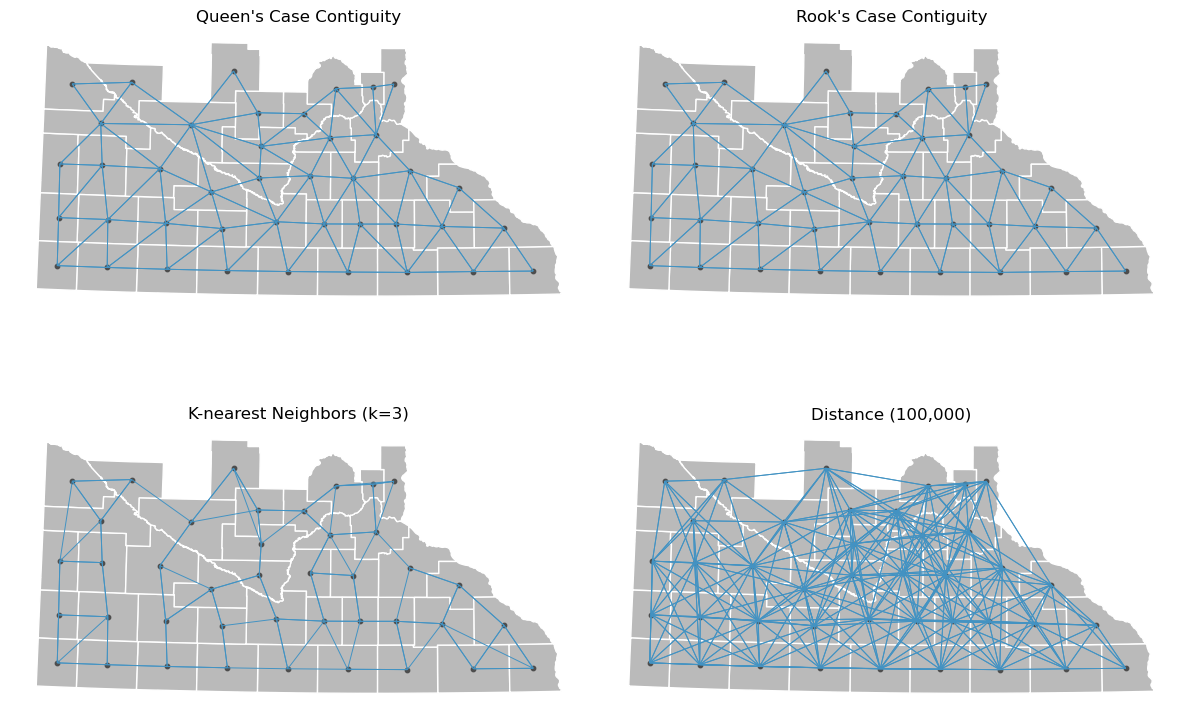

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(12, 9))
plot_spatial_weights(mnp_nbq, mnp, ax=axs[0, 0])
axs[0, 0].set_title("Queen's Case Contiguity")
plot_spatial_weights(mnp_nbr, mnp, ax=axs[0, 1])
axs[0, 1].set_title("Rook's Case Contiguity")
plot_spatial_weights(mnp_nbk3, mnp, ax=axs[1, 0])
axs[1, 0].set_title("K-nearest Neighbors (k=3)")
plot_spatial_weights(mnp_nbd, mnp, ax=axs[1, 1])
axs[1, 1].set_title("Distance (100,000)")
plt.tight_layout()

### Spatial weights transformation and weights summary
In this examples, we are setting transformations of weights and then computing an adjacency list representation of a weights object. Two different transforms are presented: `R` – Row-standardization, and `B` – Binary.

In [9]:
# Spatial Weights Summary - Row Standardized
mnp_nbq.set_transform("R")
mnp_nbq_lw_r = mnp_nbq.to_adjlist()
print ("Property s0 = {}".format(mnp_nbq.s0))
print ("Property s1 = {}".format(mnp_nbq.s1))
print ("Property s2 = {}".format(mnp_nbq.s2))
print ("Weights: {}".format(mnp_nbq.weights))
print ("Weights summary: ")
print (mnp_nbq_lw_r["weight"].describe())

Property s0 = 41.0
Property s1 = 19.071785714285713
Property s2 = 168.254410430839
Weights: {0: [0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285], 1: [0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666], 2: [0.25, 0.25, 0.25, 0.25], 3: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333], 4: [0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666], 5: [0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666], 6: [0.2, 0.2, 0.2, 0.2, 0.2], 7: [0.25, 0.25, 0.25, 0.25], 8: [0.25, 0.25, 0.25, 0.25], 9: [0.25, 0.25, 0.25, 0.25], 10: [0.2, 0.2, 0.2, 0.2, 0.2], 11: [0.25, 0.25, 0.25, 0.25], 12: [0.5, 0.5], 13: [0.25, 0.25, 0.25, 0.25], 14: [0.5, 0.5], 15: [0.16666666666666666, 0.

In [10]:
# Spatial Weights Summary - Binary
mnp_nbq.set_transform("B")
mnp_nbq_lw_b = mnp_nbq.to_adjlist()
print ("Property s0 = {}".format(mnp_nbq.s0))
print ("Property s1 = {}".format(mnp_nbq.s1))
print ("Property s2 = {}".format(mnp_nbq.s2))
print ("Weights: {}".format(mnp_nbq.weights))
print ("Weights summary: ")
print (mnp_nbq_lw_b["weight"].describe())

Property s0 = 190.0
Property s1 = 380.0
Property s2 = 3880.0
Weights: {0: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 1: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 2: [1.0, 1.0, 1.0, 1.0], 3: [1.0, 1.0, 1.0], 4: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 5: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 6: [1.0, 1.0, 1.0, 1.0, 1.0], 7: [1.0, 1.0, 1.0, 1.0], 8: [1.0, 1.0, 1.0, 1.0], 9: [1.0, 1.0, 1.0, 1.0], 10: [1.0, 1.0, 1.0, 1.0, 1.0], 11: [1.0, 1.0, 1.0, 1.0], 12: [1.0, 1.0], 13: [1.0, 1.0, 1.0, 1.0], 14: [1.0, 1.0], 15: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 16: [1.0, 1.0, 1.0], 17: [1.0, 1.0, 1.0, 1.0, 1.0], 18: [1.0, 1.0, 1.0, 1.0], 19: [1.0, 1.0, 1.0, 1.0], 20: [1.0, 1.0], 21: [1.0, 1.0, 1.0, 1.0, 1.0], 22: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 23: [1.0, 1.0, 1.0, 1.0, 1.0], 24: [1.0, 1.0, 1.0, 1.0], 25: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 26: [1.0, 1.0, 1.0, 1.0], 27: [1.0, 1.0, 1.0], 28: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 29: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 30: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 31: [1.0, 1.0, 1.0], 32: [1.0, 1.

### Spatial Autocorrelation with Moran’s I Global Statistic
Moran's I statistic measures spatial autocorrelation based on feature locations and feature values simultaneously. It allows to evaluate whether the pattern presented by the features is clustered, dispersed, or random.

In [11]:
mi = esda.moran.Moran(mnp["PEST"], mnp_nbq)
print ("Moran's I statistic: {}".format(mi.I))
print ("p-value of I under randomization assumption: {}".format(mi.p_rand))
print ("variance of I under randomization assumption: {}".format(mi.VI_rand))
print ("Expected value under normality assumption: {}".format(mi.EI))

Moran's I statistic: 0.5568801870858666
p-value of I under randomization assumption: 9.1432596014342e-09
variance of I under randomization assumption: 0.010255357545581037
Expected value under normality assumption: -0.025


### Visualize Moran's I plot

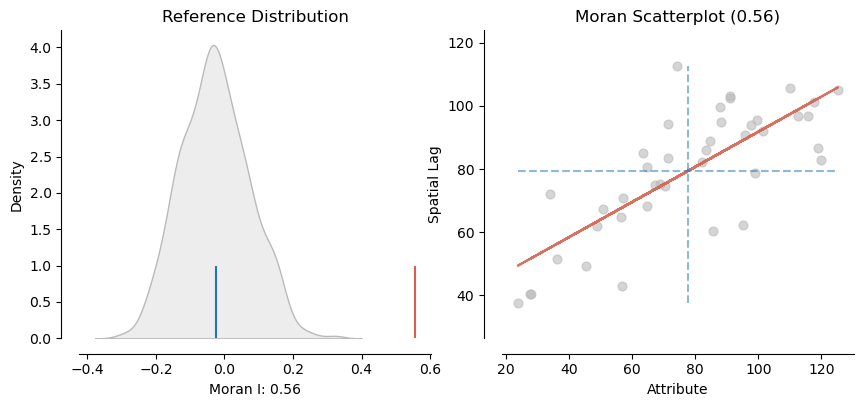

In [12]:
plot_moran(mi, zstandard=False, shade=None, fill="lightgrey")
plt.show()

### Spatial Regression Models

#### ML estimation of the spatial lag model

In [13]:
y = mnp["PEST"].to_numpy()
x = mnp[["HOST"]].values
mnp_slm = ML_Lag(y, x, mnp_nbq, name_w="Queen's Case", name_x=["HOST"], name_y="PEST", 
                 name_ds="MN Pest Pressure")
print ("Estimate of spatial autoregressive coefficient rho: {}".format(mnp_slm.rho))
print(mnp_slm.summary)

Estimate of spatial autoregressive coefficient rho: 0.729291434927095
REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :MN Pest Pressure
Weights matrix      :Queen's Case
Dependent Variable  :        PEST                Number of Observations:          41
Mean dependent var  :     77.6361                Number of Variables   :           3
S.D. dependent var  :     27.6551                Degrees of Freedom    :          38
Pseudo R-squared    :      0.6165
Spatial Pseudo R-squared:  0.2203
Sigma-square ML     :     300.256                Log likelihood        :    -178.497
S.E of regression   :      17.328                Akaike info criterion :     362.995
                                                 Schwarz criterion     :     368.136

------------------------------------------------------------------------------------
            Variable     Coefficient    

/opt/conda/envs/user_default/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


#### ML estimation of the spatial error model

In [14]:
mnp_sem = ML_Error(y, x, mnp_nbq, name_w="Queen's Case", name_x=["HOST"], name_y="PEST", 
                   name_ds="MN Pest Pressure")
print(mnp_sem.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :MN Pest Pressure
Weights matrix      :Queen's Case
Dependent Variable  :        PEST                Number of Observations:          41
Mean dependent var  :     77.6361                Number of Variables   :           2
S.D. dependent var  :     27.6551                Degrees of Freedom    :          39
Pseudo R-squared    :      0.1655
Sigma-square ML     :     294.874                Log likelihood        :    -178.539
S.E of regression   :      17.172                Akaike info criterion :     361.078
                                                 Schwarz criterion     :     364.505

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-------------------------------------------------------

#### Spatial Durbin model
Although some models are not directly offered by PySal APIs, they can be derived from existing standard models. For example, a spatial Durbin model can be estimated by computing a spatial lag of  independent variables and then adding the set of lagged variables to the original independent variables to run a spatial lag model.  

In [15]:
lag_x = weights.lag_spatial(mnp_nbq, x)
new_x = np.hstack((x,lag_x))
mnp_sdm = ML_Lag(y, new_x, mnp_nbq, name_w="Queen's Case", name_x=["HOST"], name_y="PEST", 
                 name_ds="MN Pest Pressure")
print ("Estimate of spatial autoregressive coefficient rho: {}".format(mnp_sdm.rho))
print(mnp_sdm.summary)

Estimate of spatial autoregressive coefficient rho: 0.7475149565212941
REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :MN Pest Pressure
Weights matrix      :Queen's Case
Dependent Variable  :        PEST                Number of Observations:          41
Mean dependent var  :     77.6361                Number of Variables   :           4
S.D. dependent var  :     27.6551                Degrees of Freedom    :          37
Pseudo R-squared    :      0.6265
Spatial Pseudo R-squared:  0.2139
Sigma-square ML     :     295.218                Log likelihood        :    -178.385
S.E of regression   :      17.182                Akaike info criterion :     364.770
                                                 Schwarz criterion     :     371.624

------------------------------------------------------------------------------------
            Variable     Coefficient   

#### Ordinary least squares model

In [16]:
mnp_ols = OLS(y, x, mnp_nbq, name_w="Queen's Case", name_x=["HOST"], name_y="PEST", 
                 name_ds="MN Pest Pressure", spat_diag=True)
print(mnp_ols.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :MN Pest Pressure
Weights matrix      :Queen's Case
Dependent Variable  :        PEST                Number of Observations:          41
Mean dependent var  :     77.6361                Number of Variables   :           2
S.D. dependent var  :     27.6551                Degrees of Freedom    :          39
R-squared           :      0.1655
Adjusted R-squared  :      0.1441
Sum squared residual:   25527.920                F-statistic           :      7.7368
Sigma-square        :     654.562                Prob(F-statistic)     :    0.008292
S.E. of regression  :      25.584                Log likelihood        :    -190.073
Sigma-square ML     :     622.632                Akaike info criterion :     384.145
S.E of regression ML:     24.9526                Schwarz criterion     :     387.572

-------------------------------------------------------------------------

#### Moran's I test on ordinary least squares model residuals

In [17]:
mi_ols = esda.moran.Moran(mnp_ols.u, mnp_nbq)
print ("Moran's I statistic: {}".format(mi_ols.I))
print ("p-value of I under randomization assumption: {}".format(mi_ols.p_rand))
print ("variance of I under randomization assumption: {}".format(mi_ols.VI_rand))
print ("Expected value under normality assumption: {}".format(mi_ols.EI))

Moran's I statistic: 0.5218550011069552
p-value of I under randomization assumption: 5.936343186143546e-08
variance of I under randomization assumption: 0.010177294392728933
Expected value under normality assumption: -0.025


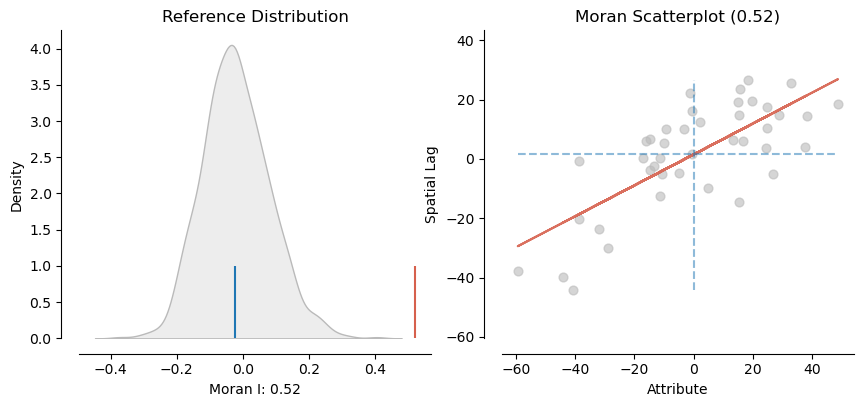

In [18]:
plot_moran(mi_ols, zstandard=False, shade=None, fill="lightgrey")
plt.show()

## Exercises
For the exercies, data are created and saved to the directory `./data-module-4/`.
- `mwi.shp` -  a dataset downloaded from the Malawi Living Standard Measurement Survey Integrated Household Sample (LSMS-IHS) Data Wave 5 Data (available from https://microdata.worldbank.org/index.php/catalog/3818).

**Question 1. Read the vector dataset `mwi.shp` into a `GeoDataFrame`. Print its Coordinate Reference System.**

**Question 2. Calculate neighboring using Queen's case (contiguity), Rook's case (contiguity), K-nearest neighbors (k=3), and distance (200,000 m). Print the properties for each neighbouring, such as number of units, number of nonzero weights, etc.**

**Question 3. Visualize and compare all 4 weights networks. What differences do you see?**

**Question 4. Apply row-standardized and binary transforms to your Queen's case neighbourhood. Compare their summaries.**

**Question 5. Run the Moran's I statistic to test the spatial autocorrelation for `poverty` variable. Use Queen's case neighbouring structure.**

**Question 6. Visualize Moran's I plot for `poverty` variable.**

**Question 7. Run ML estimation of the spatial lag model. Use Queen's case neighbouring structure. Predict `poverty` as a function of cropland cultivated (`croplnd`), livestock owned (`livstck`), share of off-farm income (`income`), years of education (`edu`), female head of household (`female`) and tobacco growing household (`tobccHH`).**

**Question 8. Run the Ordinary least squares model. Use Queen's case neighbouring structure. Use the same `x` and `y` variables as for the previous question.**